In [1]:
# calculate elapsed time
import time
start_time = time.time()

#### IMPORT

In [2]:
import os, platform
import py7zr

from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

from keras.utils.np_utils import to_categorical 
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Dropout, \
    BatchNormalization, Flatten, LSTM
# from scikeras.wrappers import KerasClassifier
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import load_model

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, auc

from itertools import cycle
from scipy import interp
from scipy.optimize import brentq
from scipy.interpolate import interp1d

#### PARAMETERS
- Set the condition
> * N_FEATURES: Number of Features
> * CHECK_BLANKS: Check for blank data. If any blank data is found, the whole row of data will be deleted.
> * CHECK_CLASS_IMBALANCE: Check for dataset class imbalance. The more balance the dataset, the less biases the model will be.

In [3]:
##############################
# # deep learning features # #
##############################
SEED = 1005 # random seed for reproducibility

# should make this dynamic
N_FEATURES = 220
TIMESTEPS = 1
EPOCH=400
BATCH_SIZE=10

SPLIT_RATIO=0.2

###############
# # preview # #
###############
f = False
t = True

# checking dataset
CHECK_BLANKS = True
CHECK_CLASS_IMBALANCE = True

# evaluate suitable kfold number and kfold model
MIN_KFOLD = 2
MAX_KFOLD = 11
N_KFOLD = 5
EVAL_KFOLD_NUM = False
EVAL_KFOLD_MODEL = False
PERFORM_KFOLD = True

# model testing
TEST_MODEL = True
CON_MATRIX = True
ROC_GRAPH = True

###############
# # dataset # #
###############
CLASSES_COL_NAME = "Subject"
CLASSES_COL_NUM = 0
FEATURES_COL_NUM = 2

DATASET_DIR_NAME = "dataset\set04\\01_own"
SAMPLE_DATASET_NAME = "own_train"
ACTUAL_DATASET_NAME = "own_test"

MODEL_DIR_NAME = "dataset\set04\\01_own"
MODEL_NAME = "model_" + "set04_01_own"

RESULT_DIR_NAME = "dataset\set04\\01_own"
RESULT_NAME = "result_" + "set04_01_own"

DATASET_DIR_PATH = os.path.join(os.getcwd(), DATASET_DIR_NAME)
SAMPLE_DATASET_PATH = os.path.join(DATASET_DIR_PATH, SAMPLE_DATASET_NAME + ".csv")
ACTUAL_DATASET_PATH = os.path.join(DATASET_DIR_PATH, ACTUAL_DATASET_NAME + ".csv")

MODEL_DIR_PATH = os.path.join(os.getcwd(), MODEL_DIR_NAME)
MODEL_PATH = os.path.join(MODEL_DIR_PATH, MODEL_NAME + ".h5")

RESULT_DIR_PATH = os.path.join(os.getcwd(), RESULT_DIR_NAME)
RESULT_PATH = os.path.join(RESULT_DIR_PATH, RESULT_NAME + ".csv")

#################
# # sns theme # #
#################
# sns.set_theme(style="darkgrid") # (dark background with white gridlines)
sns.set_theme(style="whitegrid") # (white background with grey gridlines)
# sns.set_theme(style="dark") # (dark background with no gridlines)
# sns.set_theme(style="white") # (white background with no gridlines)
# sns.set_theme(style="ticks") # (white background with axis ticks and no gridlines)

In [4]:
if os.path.isdir(DATASET_DIR_PATH) is True:
    print(f"Dataset directory exists at: {DATASET_DIR_PATH}")
else:
    try:
        os.mkdir(DATASET_DIR_PATH, 666)
        print(f"Dataset directory have been created at: {DATASET_DIR_PATH}")
    except:
        print("Error: Dataset Directory not created")
        
if os.path.isdir(MODEL_DIR_PATH) is True:
    print(f"Model directory exists at: {MODEL_DIR_PATH}")
else:
    try:
        os.mkdir(MODEL_DIR_PATH, 666)
        print(f"Model directory have been created at: {MODEL_DIR_PATH}")
    except:
        print("Error: Model Directory not created")
    
if os.path.exists(SAMPLE_DATASET_PATH) is True:
    print(f"Training dataset exists at: {SAMPLE_DATASET_PATH}")
else:
    try:
        SAMPLE_7Z_PATH = os.path.join(DATASET_DIR_PATH, SAMPLE_DATASET_NAME + ".7z")
        with py7zr.SevenZipFile(SAMPLE_7Z_PATH, mode='r') as z:
            z.extractall(path=DATASET_DIR_PATH)
        print(f"Decompress 7z file to: {SAMPLE_7Z_PATH}")
    except:
        print("Error: Failed to decompress 7z file.")

Dataset directory exists at: C:\Users\andyc\Documents\GitHub\ict4001-cap\dataset\set04\01_own
Model directory exists at: C:\Users\andyc\Documents\GitHub\ict4001-cap\dataset\set04\01_own
Training dataset exists at: C:\Users\andyc\Documents\GitHub\ict4001-cap\dataset\set04\01_own\own_train.csv


#### CREATE MODEL
- Create base model
- Wrap it with KerasClassifier

In [5]:
#create base model
def create_base_model():
    model = Sequential()
    model.add(LSTM(units=256, return_sequences=True,
             input_shape=(TIMESTEPS,N_FEATURES)))
    model.add(Dense(256, activation='sigmoid'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(LSTM(units=128, return_sequences=True))
    model.add(Dense(128, activation='sigmoid'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(LSTM(units=64, return_sequences=True))
    model.add(Dense(64, activation='sigmoid'))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(LSTM(units=32, return_sequences=True))
    model.add(Dense(32, activation='sigmoid'))
    model.add(Dropout(0.2))

    # softmax for multi-class classification
    model.add(Flatten())
    print("There are a total of " + str(n_classes) + " classes.")
    model.add(Dense(n_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam',
                metrics=['accuracy'])
    return model

# wrap model in KerasClassifier
def create_model():
    model = KerasClassifier(build_fn=create_base_model, epochs=EPOCH, 
                            batch_size=BATCH_SIZE)
    return model

In [6]:
# divide data into features X and target (classes) Y
def prepare_dataset(df):
    X = df.values[:,FEATURES_COL_NUM:].astype(float)
    Y = df.values[:,CLASSES_COL_NUM].astype(str)

    # convert target Y to labelbinarizer Y for model
    # fit_transform is not used to reuse lb
    Y = Y.reshape(-1, 1)
    lb = LabelBinarizer().fit(Y)
    Y = lb.transform(Y)

    #################################
    # # get all the encoded class # #
    #################################
    print("LabelBinarizer is able to decipher: ")
    print(lb.classes_)
    print("\n")

    ###########################
    # # print X and Y shape # #
    ###########################
    print(f"X | Features | Dataset Shape: {X.shape}")
    print(f"Y | Classes  | Dataset Shape: {Y.shape}")

    return X, Y, lb, lb.classes_.tolist()

In [7]:
def split_shape_dataset(X, Y, SPLIT_RATIO, TIMESTEPS, SEED):

    ##############################################################
    # # split dataset into train and test set of 0.8/0.2 ratio # #
    ##############################################################
    X_train, X_test, y_train, y_test = train_test_split(
        X, Y, test_size=SPLIT_RATIO, random_state=SEED)

    ############################
    # # reshaping of dataset # #
    ############################

    # reshaping the dataset to include LSTM Timesteps
    print(X_train.dtype)
    X_train = np.asarray(X_train, dtype=np.float32)
    print(X_train.dtype)
    X_train = np.reshape(X_train, (X_train.shape[0], TIMESTEPS, X_train.shape[1]))
    print(X_test.dtype)
    X_test = np.asarray(X_test, dtype=np.float32)
    print(X_test.dtype)
    X_test = np.reshape(X_test, (X_test.shape[0], TIMESTEPS, X_test.shape[1]))

    print(f"X train shape: {X_train.shape}")
    print(f"Y train shape: {y_train.shape}")
    print(f"X test shape: {X_test.shape}")
    print(f"Y test shape: {y_test.shape}")
    
    return X_train, X_test, y_train, y_test

def reshape_dataset(X, TIMESTEPS):
    # reshaping the dataset to include LSTM Timesteps
    X = np.asarray(X, dtype=np.float32)
    X = np.reshape(X, (X.shape[0], TIMESTEPS, X.shape[1]))
    return X

#### LOAD DATASET

In [8]:
# load dataset
df = pd.read_csv(SAMPLE_DATASET_PATH)
df.head()

,Subject,Password,T2-D|0,T2-I|0+1,T2-PF|0+1,T2-RF|0+1,T2-NG|0+1,T2-D|1,T2-I|1+2,T2-PF|1+2,...,T7-RF|VAR,T7-NG|VAR,T7-I|SD,T7-PF|SD,T7-RF|SD,T7-NG|SD,T8-I|0+7,T8-PF|0+7,T8-RF|0+7,T8-NG|0+7
0,andy,Co5mical,0.124989,0.000000,0.124989,0.123640,0.248628,0.123640,0.011015,0.134655,...,0.005318,0.005458,0.055285,0.056239,0.072921,0.073875,0.606169,0.731157,0.718543,0.843531
1,andy,Co5mical,0.101935,0.011014,0.112950,0.133594,0.235529,0.122580,0.046207,0.168787,...,0.006047,0.003990,0.047034,0.032436,0.077762,0.063164,0.616391,0.718327,0.697449,0.799384
2,andy,Co5mical,0.090341,-0.012504,0.077837,0.090850,0.181191,0.103354,0.054714,0.158068,...,0.003187,0.002233,0.024718,0.015517,0.056457,0.047256,0.550968,0.641309,0.628636,0.718976
3,andy,Co5mical,0.102711,0.011565,0.114277,0.110634,0.213346,0.099069,0.033884,0.132953,...,0.004878,0.005244,0.046083,0.048659,0.069841,0.072416,0.562252,0.664963,0.652923,0.755634
4,andy,Co5mical,0.127922,0.063317,0.191239,0.188074,0.315996,0.124757,0.023144,0.147900,...,0.016760,0.017344,0.101889,0.104127,0.129459,0.131697,0.638064,0.765986,0.722751,0.850673


#### CHECK DATASET

Checking for blanks...
No blank value has been found.
Checking for class imbalance...


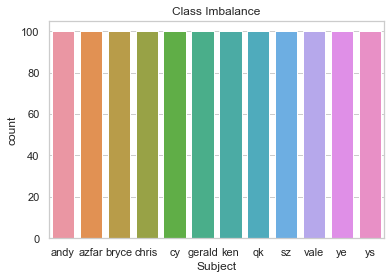

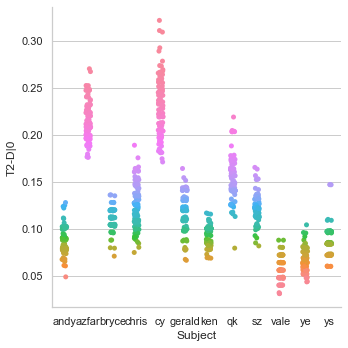

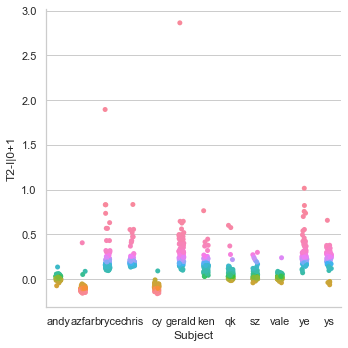

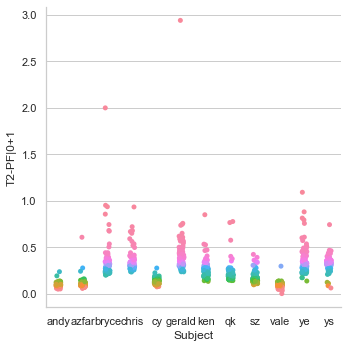

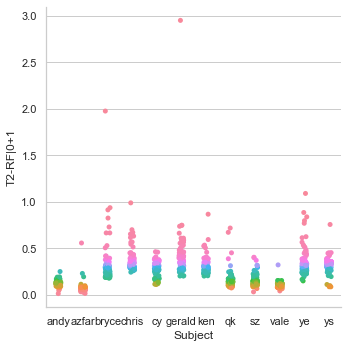

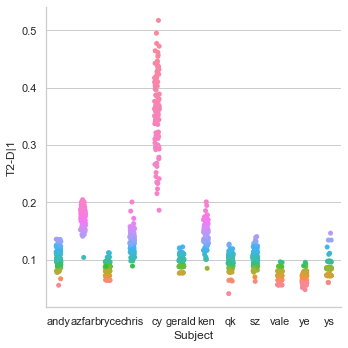

In [9]:
########################
# # check for blanks # #
########################
if CHECK_BLANKS is True:
    # checking for blanks
    print("Checking for blanks...")
    if df.isnull().values.any() is True:
        df = df.dropna(axis=0, how="any")
        print("Blank rows has been dropped.")
    else:
        print("No blank value has been found.")
        
#################################
# # check for class imbalance # #
#################################
if CHECK_CLASS_IMBALANCE is True:
    print("Checking for class imbalance...")
    sns.countplot(x=CLASSES_COL_NAME, data=df).set_title("Class Imbalance")
#     df.loc[(df!=0).any(axis=1)]
    plt.show()

sns.catplot(x="Subject", y="T2-D|0", hue="T2-D|0", data=df, legend=False)
sns.catplot(x="Subject", y="T2-I|0+1", hue="T2-I|0+1", data=df, legend=False)
sns.catplot(x="Subject", y="T2-PF|0+1", hue="T2-PF|0+1", data=df, legend=False)
sns.catplot(x="Subject", y="T2-RF|0+1", hue="T2-RF|0+1", data=df, legend=False)
sns.catplot(x="Subject", y="T2-D|1", hue="T2-D|1", data=df, legend=False)

#### PREPARE DATASET
- Split data based on X / Features and Y / Classes
- Binarize Y into binary labels

In [10]:
X, Y, lb, class_list = prepare_dataset(df)
n_classes = len(class_list)
print(f"Number of Classes: {n_classes}")

LabelBinarizer is able to decipher: 
['andy' 'azfar' 'bryce' 'chris' 'cy' 'gerald' 'ken' 'qk' 'sz' 'vale' 'ye'
 'ys']


X | Features | Dataset Shape: (1200, 220)
Y | Classes  | Dataset Shape: (1200, 12)
Number of Classes: 12


#### SPLIT DATASET
- Split dataset into train set and test set 0.8 / 0.2

In [11]:
##############################################################
# # split dataset into train and test set of 0.8/0.2 ratio # #
##############################################################
X_train, X_test, y_train, y_test = split_shape_dataset(X, Y, SPLIT_RATIO, TIMESTEPS, SEED)

float64
float32
float64
float32
X train shape: (960, 1, 220)
Y train shape: (960, 12)
X test shape: (240, 1, 220)
Y test shape: (240, 12)


#### PERFORM VALIDATION (w KFold Validation)
- Evaluate best KFold Validation
- Generate loss and accuracy graph
- Perform KFold validation

##### Evaluate suitable folds for kfold validation

In [12]:
###############################################
# # evaluate suitable kfold value for model # #
###############################################
def evaluate_kfold(X_train, y_train, SEED, MIN_KFOLD, MAX_KFOLD):
    
    # evaluate the model    
    folds = range(MIN_KFOLD, MAX_KFOLD)
    means, mins, maxs = list(), list(), list()
    
    # evaluate each k value
    for k in folds:
        # define the test condition
        kfold = KFold(n_splits=k, shuffle=True, random_state=SEED)
        
        # evaluate k value
        model = create_model()
        scores = cross_val_score(model, X_train, y_train, cv=kfold, n_jobs=-1)
        
        k_mean = np.mean(scores)
        k_min = scores.min()
        k_max = scores.max()
        
        # report performance
        print(f"No. of Folds: {k} | Accuracy: {k_mean*100:.3f} | Min: {k_min*100:.3f} | Max: {k_max*100:.3f}")
        
        # store mean accuracy and min and max relative to the mean
        means.append(k_mean)
        mins.append(k_mean - k_min)
        maxs.append(k_max - k_mean)
        
    # line plot of k mean values with min/max error bars
    clear_output(wait=True)
    pyplot.errorbar(folds, means, yerr=[mins, maxs], fmt='o')
    
    # show the plot
    pyplot.show()
    
if EVAL_KFOLD_NUM is True:
    evaluate_kfold(X_train, y_train, SEED, MIN_KFOLD, MAX_KFOLD)
else:
    print("EVAL_KFOLD_NUM is not True")

EVAL_KFOLD_NUM is not True


##### Generate kfold validation accuracy and loss

In [13]:
##################################################
# # evaluate kfold model for accuracy and loss # #
##################################################
def evaluate_kfold_model(X_train, y_train, SEED):
    scores, histories = list(), list()
    # create model
    model = create_model()
    # prepare cross validation
    kfold = KFold(n_splits=5, shuffle=True, random_state=SEED)
    # enumerate splits
    for train_ix, test_ix in kfold.split(X_train):
        # select rows for train and test
        trainX, trainY, testX, testY = X_train[train_ix], y_train[train_ix], X_train[test_ix], y_train[test_ix]
        # fit model
        history = model.fit(trainX, trainY, epochs=100, batch_size=50, validation_data=(testX, testY), verbose=0)
        
        # evaluate model
        y_pred = model.predict(testX)
        y_pred = to_categorical(y_pred)

        # evaluate predictions
        acc = accuracy_score(testY, y_pred)
        print("Testing accuracy: %.3f%%" % (acc*100))

        # stores scores and histories
        scores.append(acc)
        histories.append(history)

    for i in range(len(histories)):
        # plot loss
        f1 = plt.figure(1)
        plt.title('Categorical Cross-Entropy Loss')
        plt.plot(histories[i].history['loss'], color='blue')
        plt.plot(histories[i].history['val_loss'], color='orange')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper right')

        # plot accuracy
        f2 = plt.figure(2)
        plt.title('Classification Accuracy')
        plt.plot(histories[i].history['accuracy'], color='blue')
        plt.plot(histories[i].history['val_accuracy'], color='orange')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='lower right')

    # print summary
    print(f"Accuracy | Mean: {np.mean(scores)*100:.3f} | Std: {np.std(scores)*100:.3f} | Length/no.: {len(scores)}")
    # box and whisker plots of results
    f3 = plt.figure(3)
    plt.title('Box and Whisker Plot of Accuracy Scores')
    plt.ylabel('accuracy')
    plt.xlabel('model')
    plt.boxplot(scores)
    clear_output(wait=True)
    plt.show()
    
if EVAL_KFOLD_MODEL is True:
    evaluate_kfold_model(X_train, y_train, SEED)
else:
    print("EVAL_KFOLD_MODEL is not true")

EVAL_KFOLD_MODEL is not true


##### Perform Actual KFold validation

In [14]:
if PERFORM_KFOLD is True:
    # create model
    model = create_model()
    kfold = KFold(n_splits=N_KFOLD, shuffle=True, random_state=SEED)
    valid_score = cross_val_score(model, X_train, y_train, 
                          cv=kfold, error_score="raise", verbose=0)
else:
    print("PERFORM_KFOLD is not true.")

There are a total of 12 classes.
Epoch 1/400
77/77 [==============================] - 6s 9ms/step - loss: 2.5570 - accuracy: 0.0833
Epoch 2/400
77/77 [==============================] - 1s 9ms/step - loss: 2.4836 - accuracy: 0.1029
Epoch 3/400
77/77 [==============================] - 1s 9ms/step - loss: 2.3771 - accuracy: 0.1641
Epoch 4/400
77/77 [==============================] - 1s 9ms/step - loss: 2.2907 - accuracy: 0.1576
Epoch 5/400
77/77 [==============================] - 1s 9ms/step - loss: 2.2210 - accuracy: 0.1719
Epoch 6/400
77/77 [==============================] - 1s 9ms/step - loss: 2.1461 - accuracy: 0.1992
Epoch 7/400
77/77 [==============================] - 1s 9ms/step - loss: 2.1178 - accuracy: 0.1667
Epoch 8/400
77/77 [==============================] - 1s 9ms/step - loss: 2.0607 - accuracy: 0.1992
Epoch 9/400
77/77 [==============================] - 1s 9ms/step - loss: 2.0130 - accuracy: 0.2227
Epoch 10/400
77/77 [==============================] - 1s 9ms/step - loss: 2.

77/77 [==============================] - 1s 9ms/step - loss: 1.3757 - accuracy: 0.4115
Epoch 83/400
77/77 [==============================] - 1s 9ms/step - loss: 1.2999 - accuracy: 0.4544
Epoch 84/400
77/77 [==============================] - 1s 9ms/step - loss: 1.2764 - accuracy: 0.4518
Epoch 85/400
77/77 [==============================] - 1s 9ms/step - loss: 1.3911 - accuracy: 0.4219
Epoch 86/400
77/77 [==============================] - 1s 9ms/step - loss: 1.3185 - accuracy: 0.4323
Epoch 87/400
77/77 [==============================] - 1s 9ms/step - loss: 1.3290 - accuracy: 0.4466
Epoch 88/400
77/77 [==============================] - 1s 9ms/step - loss: 1.2341 - accuracy: 0.4753
Epoch 89/400
77/77 [==============================] - 1s 9ms/step - loss: 1.2698 - accuracy: 0.4557
Epoch 90/400
77/77 [==============================] - 1s 9ms/step - loss: 1.2277 - accuracy: 0.4792
Epoch 91/400
77/77 [==============================] - 1s 9ms/step - loss: 1.2989 - accuracy: 0.4609
Epoch 92/400


77/77 [==============================] - 1s 9ms/step - loss: 1.0025 - accuracy: 0.6497
Epoch 164/400
77/77 [==============================] - 1s 9ms/step - loss: 0.9507 - accuracy: 0.6719
Epoch 165/400
77/77 [==============================] - 1s 9ms/step - loss: 0.8323 - accuracy: 0.6953
Epoch 166/400
77/77 [==============================] - 1s 9ms/step - loss: 0.8811 - accuracy: 0.6628
Epoch 167/400
77/77 [==============================] - 1s 9ms/step - loss: 0.8883 - accuracy: 0.6888
Epoch 168/400
77/77 [==============================] - 1s 9ms/step - loss: 0.9586 - accuracy: 0.6745
Epoch 169/400
77/77 [==============================] - 1s 9ms/step - loss: 0.9093 - accuracy: 0.6823
Epoch 170/400
77/77 [==============================] - 1s 9ms/step - loss: 0.8886 - accuracy: 0.6771
Epoch 171/400
77/77 [==============================] - 1s 9ms/step - loss: 0.8576 - accuracy: 0.6901
Epoch 172/400
77/77 [==============================] - 1s 9ms/step - loss: 0.9105 - accuracy: 0.6745
Epoc

77/77 [==============================] - 1s 9ms/step - loss: 0.8247 - accuracy: 0.7070
Epoch 245/400
77/77 [==============================] - 1s 9ms/step - loss: 0.8072 - accuracy: 0.7005
Epoch 246/400
77/77 [==============================] - 1s 9ms/step - loss: 0.7984 - accuracy: 0.7096
Epoch 247/400
77/77 [==============================] - 1s 9ms/step - loss: 0.7132 - accuracy: 0.7435
Epoch 248/400
77/77 [==============================] - 1s 9ms/step - loss: 0.7763 - accuracy: 0.7201
Epoch 249/400
77/77 [==============================] - 1s 9ms/step - loss: 0.8338 - accuracy: 0.6875
Epoch 250/400
77/77 [==============================] - 1s 9ms/step - loss: 0.8000 - accuracy: 0.7018
Epoch 251/400
77/77 [==============================] - 1s 9ms/step - loss: 0.7748 - accuracy: 0.7240
Epoch 252/400
77/77 [==============================] - 1s 9ms/step - loss: 0.7510 - accuracy: 0.7148
Epoch 253/400
77/77 [==============================] - 1s 9ms/step - loss: 0.7224 - accuracy: 0.7461
Epoc

77/77 [==============================] - 1s 9ms/step - loss: 0.5259 - accuracy: 0.8529
Epoch 326/400
77/77 [==============================] - 1s 9ms/step - loss: 0.5194 - accuracy: 0.8594
Epoch 327/400
77/77 [==============================] - 1s 9ms/step - loss: 0.4412 - accuracy: 0.8750
Epoch 328/400
77/77 [==============================] - 1s 9ms/step - loss: 0.4354 - accuracy: 0.8841
Epoch 329/400
77/77 [==============================] - 1s 9ms/step - loss: 0.5234 - accuracy: 0.8555
Epoch 330/400
77/77 [==============================] - 1s 10ms/step - loss: 0.5665 - accuracy: 0.8464
Epoch 331/400
77/77 [==============================] - 1s 9ms/step - loss: 0.5949 - accuracy: 0.8307
Epoch 332/400
77/77 [==============================] - 1s 9ms/step - loss: 0.4675 - accuracy: 0.8750
Epoch 333/400
77/77 [==============================] - 1s 9ms/step - loss: 0.4669 - accuracy: 0.8607
Epoch 334/400
77/77 [==============================] - 1s 9ms/step - loss: 0.5149 - accuracy: 0.8633
Epo

77/77 [==============================] - 1s 9ms/step - loss: 2.2712 - accuracy: 0.1654
Epoch 6/400
77/77 [==============================] - 1s 9ms/step - loss: 2.1923 - accuracy: 0.1836
Epoch 7/400
77/77 [==============================] - 1s 9ms/step - loss: 2.1235 - accuracy: 0.1979
Epoch 8/400
77/77 [==============================] - 1s 9ms/step - loss: 2.0854 - accuracy: 0.1940
Epoch 9/400
77/77 [==============================] - 1s 9ms/step - loss: 2.0465 - accuracy: 0.2201
Epoch 10/400
77/77 [==============================] - 1s 9ms/step - loss: 2.0012 - accuracy: 0.2292
Epoch 11/400
77/77 [==============================] - 1s 9ms/step - loss: 1.9595 - accuracy: 0.2161
Epoch 12/400
77/77 [==============================] - 1s 9ms/step - loss: 1.9258 - accuracy: 0.2318
Epoch 13/400
77/77 [==============================] - 1s 9ms/step - loss: 1.9807 - accuracy: 0.2500
Epoch 14/400
77/77 [==============================] - 1s 9ms/step - loss: 1.8324 - accuracy: 0.2344
Epoch 15/400
77/7

77/77 [==============================] - 1s 9ms/step - loss: 1.1503 - accuracy: 0.5078
Epoch 88/400
77/77 [==============================] - 1s 9ms/step - loss: 1.1602 - accuracy: 0.5352
Epoch 89/400
77/77 [==============================] - 1s 9ms/step - loss: 1.1784 - accuracy: 0.5273
Epoch 90/400
77/77 [==============================] - 1s 9ms/step - loss: 1.1774 - accuracy: 0.4896
Epoch 91/400
77/77 [==============================] - 1s 9ms/step - loss: 1.2025 - accuracy: 0.5273
Epoch 92/400
77/77 [==============================] - 1s 9ms/step - loss: 1.2307 - accuracy: 0.4922
Epoch 93/400
77/77 [==============================] - 1s 9ms/step - loss: 1.2293 - accuracy: 0.5286
Epoch 94/400
77/77 [==============================] - 1s 9ms/step - loss: 1.1119 - accuracy: 0.5169
Epoch 95/400
77/77 [==============================] - 1s 9ms/step - loss: 1.1384 - accuracy: 0.5117
Epoch 96/400
77/77 [==============================] - 1s 9ms/step - loss: 1.1131 - accuracy: 0.5378
Epoch 97/400


77/77 [==============================] - 1s 9ms/step - loss: 0.8122 - accuracy: 0.6771
Epoch 169/400
77/77 [==============================] - 1s 9ms/step - loss: 0.9230 - accuracy: 0.6576
Epoch 170/400
77/77 [==============================] - 1s 9ms/step - loss: 0.8719 - accuracy: 0.6549
Epoch 171/400
77/77 [==============================] - 1s 9ms/step - loss: 0.8523 - accuracy: 0.6784
Epoch 172/400
77/77 [==============================] - 1s 9ms/step - loss: 0.8004 - accuracy: 0.6966
Epoch 173/400
77/77 [==============================] - 1s 9ms/step - loss: 0.7856 - accuracy: 0.6992
Epoch 174/400
77/77 [==============================] - 1s 9ms/step - loss: 0.7568 - accuracy: 0.6979
Epoch 175/400
77/77 [==============================] - 1s 9ms/step - loss: 0.7967 - accuracy: 0.7135
Epoch 176/400
77/77 [==============================] - 1s 9ms/step - loss: 0.8119 - accuracy: 0.6510
Epoch 177/400
77/77 [==============================] - 1s 9ms/step - loss: 0.8265 - accuracy: 0.6953
Epoc

77/77 [==============================] - 1s 9ms/step - loss: 0.7097 - accuracy: 0.7461
Epoch 250/400
77/77 [==============================] - 1s 9ms/step - loss: 0.6620 - accuracy: 0.7630
Epoch 251/400
77/77 [==============================] - 1s 9ms/step - loss: 0.6730 - accuracy: 0.7448
Epoch 252/400
77/77 [==============================] - 1s 9ms/step - loss: 0.6732 - accuracy: 0.7578
Epoch 253/400
77/77 [==============================] - 1s 10ms/step - loss: 0.5392 - accuracy: 0.7839
Epoch 254/400
77/77 [==============================] - 1s 9ms/step - loss: 0.6660 - accuracy: 0.7344
Epoch 255/400
77/77 [==============================] - 1s 9ms/step - loss: 0.6810 - accuracy: 0.7526
Epoch 256/400
77/77 [==============================] - 1s 9ms/step - loss: 0.7213 - accuracy: 0.7513
Epoch 257/400
77/77 [==============================] - 1s 9ms/step - loss: 0.6662 - accuracy: 0.7565
Epoch 258/400
77/77 [==============================] - 1s 9ms/step - loss: 0.6945 - accuracy: 0.7539
Epo

77/77 [==============================] - 1s 9ms/step - loss: 0.5004 - accuracy: 0.8672
Epoch 331/400
77/77 [==============================] - 1s 9ms/step - loss: 0.5010 - accuracy: 0.8815
Epoch 332/400
77/77 [==============================] - 1s 9ms/step - loss: 0.5591 - accuracy: 0.8594
Epoch 333/400
77/77 [==============================] - 1s 9ms/step - loss: 0.5490 - accuracy: 0.8346
Epoch 334/400
77/77 [==============================] - 1s 9ms/step - loss: 0.4453 - accuracy: 0.8711
Epoch 335/400
77/77 [==============================] - 1s 9ms/step - loss: 0.4883 - accuracy: 0.8854
Epoch 336/400
77/77 [==============================] - 1s 9ms/step - loss: 0.4817 - accuracy: 0.8581
Epoch 337/400
77/77 [==============================] - 1s 9ms/step - loss: 0.5502 - accuracy: 0.8529
Epoch 338/400
77/77 [==============================] - 1s 9ms/step - loss: 0.5514 - accuracy: 0.8594
Epoch 339/400
77/77 [==============================] - 1s 9ms/step - loss: 0.4725 - accuracy: 0.8724
Epoc

77/77 [==============================] - 1s 10ms/step - loss: 2.1008 - accuracy: 0.1771
Epoch 11/400
77/77 [==============================] - 1s 10ms/step - loss: 2.0645 - accuracy: 0.1849
Epoch 12/400
77/77 [==============================] - 1s 10ms/step - loss: 2.0270 - accuracy: 0.2122
Epoch 13/400
77/77 [==============================] - 1s 10ms/step - loss: 2.0099 - accuracy: 0.2109
Epoch 14/400
77/77 [==============================] - 1s 10ms/step - loss: 1.9977 - accuracy: 0.2031
Epoch 15/400
77/77 [==============================] - 1s 10ms/step - loss: 1.9917 - accuracy: 0.2409
Epoch 16/400
77/77 [==============================] - 1s 10ms/step - loss: 1.9604 - accuracy: 0.2188
Epoch 17/400
77/77 [==============================] - 1s 10ms/step - loss: 1.9211 - accuracy: 0.2565
Epoch 18/400
77/77 [==============================] - 1s 10ms/step - loss: 1.8887 - accuracy: 0.2578
Epoch 19/400
77/77 [==============================] - 1s 10ms/step - loss: 1.8845 - accuracy: 0.2826
Epo

77/77 [==============================] - 1s 10ms/step - loss: 1.1225 - accuracy: 0.5273
Epoch 92/400
77/77 [==============================] - 1s 11ms/step - loss: 1.1992 - accuracy: 0.5026
Epoch 93/400
77/77 [==============================] - 1s 10ms/step - loss: 1.1689 - accuracy: 0.5417
Epoch 94/400
77/77 [==============================] - 1s 10ms/step - loss: 1.1727 - accuracy: 0.5182
Epoch 95/400
77/77 [==============================] - 1s 10ms/step - loss: 1.1527 - accuracy: 0.5013
Epoch 96/400
77/77 [==============================] - 1s 10ms/step - loss: 1.1031 - accuracy: 0.5169
Epoch 97/400
77/77 [==============================] - 1s 10ms/step - loss: 1.0450 - accuracy: 0.5951
Epoch 98/400
77/77 [==============================] - 1s 10ms/step - loss: 1.0563 - accuracy: 0.5664
Epoch 99/400
77/77 [==============================] - 1s 10ms/step - loss: 1.1118 - accuracy: 0.5456
Epoch 100/400
77/77 [==============================] - 1s 10ms/step - loss: 1.1104 - accuracy: 0.5365
Ep

77/77 [==============================] - 1s 10ms/step - loss: 0.7236 - accuracy: 0.7682
Epoch 172/400
77/77 [==============================] - 1s 10ms/step - loss: 0.7058 - accuracy: 0.7695
Epoch 173/400
77/77 [==============================] - 1s 10ms/step - loss: 0.7199 - accuracy: 0.7773
Epoch 174/400
77/77 [==============================] - 1s 10ms/step - loss: 0.7171 - accuracy: 0.7786
Epoch 175/400
77/77 [==============================] - 1s 10ms/step - loss: 0.7484 - accuracy: 0.7578
Epoch 176/400
77/77 [==============================] - 1s 10ms/step - loss: 0.7169 - accuracy: 0.7865
Epoch 177/400
77/77 [==============================] - 1s 10ms/step - loss: 0.6459 - accuracy: 0.8190
Epoch 178/400
77/77 [==============================] - 1s 10ms/step - loss: 0.6276 - accuracy: 0.8216
Epoch 179/400
77/77 [==============================] - 1s 10ms/step - loss: 0.6075 - accuracy: 0.8320
Epoch 180/400
77/77 [==============================] - 1s 11ms/step - loss: 0.6458 - accuracy: 0

77/77 [==============================] - 1s 10ms/step - loss: 0.4754 - accuracy: 0.8737
Epoch 252/400
77/77 [==============================] - 1s 10ms/step - loss: 0.4263 - accuracy: 0.9023
Epoch 253/400
77/77 [==============================] - 1s 10ms/step - loss: 0.5128 - accuracy: 0.8958
Epoch 254/400
77/77 [==============================] - 1s 10ms/step - loss: 0.4569 - accuracy: 0.8776
Epoch 255/400
77/77 [==============================] - 1s 10ms/step - loss: 0.4056 - accuracy: 0.9167
Epoch 256/400
77/77 [==============================] - 1s 10ms/step - loss: 0.4695 - accuracy: 0.8919
Epoch 257/400
77/77 [==============================] - 1s 10ms/step - loss: 0.5479 - accuracy: 0.8737
Epoch 258/400
77/77 [==============================] - 1s 10ms/step - loss: 0.5111 - accuracy: 0.8711
Epoch 259/400
77/77 [==============================] - 1s 10ms/step - loss: 0.4921 - accuracy: 0.8880
Epoch 260/400
77/77 [==============================] - 1s 10ms/step - loss: 0.4914 - accuracy: 0

77/77 [==============================] - 1s 10ms/step - loss: 0.3868 - accuracy: 0.9089
Epoch 332/400
77/77 [==============================] - 1s 10ms/step - loss: 0.3051 - accuracy: 0.9349
Epoch 333/400
77/77 [==============================] - 1s 10ms/step - loss: 0.3364 - accuracy: 0.9232
Epoch 334/400
77/77 [==============================] - 1s 10ms/step - loss: 0.3164 - accuracy: 0.9167
Epoch 335/400
77/77 [==============================] - 1s 11ms/step - loss: 0.4074 - accuracy: 0.9062
Epoch 336/400
77/77 [==============================] - 1s 10ms/step - loss: 0.3877 - accuracy: 0.9180
Epoch 337/400
77/77 [==============================] - 1s 10ms/step - loss: 0.2339 - accuracy: 0.9505
Epoch 338/400
77/77 [==============================] - 1s 10ms/step - loss: 0.3052 - accuracy: 0.9414
Epoch 339/400
77/77 [==============================] - 1s 10ms/step - loss: 0.3562 - accuracy: 0.9193
Epoch 340/400
77/77 [==============================] - 1s 10ms/step - loss: 0.3688 - accuracy: 0

77/77 [==============================] - 1s 11ms/step - loss: 1.9346 - accuracy: 0.2526
Epoch 11/400
77/77 [==============================] - 1s 10ms/step - loss: 1.9286 - accuracy: 0.2266
Epoch 12/400
77/77 [==============================] - 1s 11ms/step - loss: 1.9405 - accuracy: 0.2448
Epoch 13/400
77/77 [==============================] - 1s 11ms/step - loss: 1.9206 - accuracy: 0.2552
Epoch 14/400
77/77 [==============================] - 1s 11ms/step - loss: 1.8706 - accuracy: 0.2370
Epoch 15/400
77/77 [==============================] - 1s 10ms/step - loss: 1.8512 - accuracy: 0.2318
Epoch 16/400
77/77 [==============================] - 1s 11ms/step - loss: 1.8745 - accuracy: 0.2357
Epoch 17/400
77/77 [==============================] - 1s 10ms/step - loss: 1.8075 - accuracy: 0.2760
Epoch 18/400
77/77 [==============================] - 1s 10ms/step - loss: 1.8489 - accuracy: 0.2461
Epoch 19/400
77/77 [==============================] - 1s 10ms/step - loss: 1.7993 - accuracy: 0.2279
Epo

77/77 [==============================] - 1s 10ms/step - loss: 1.2086 - accuracy: 0.5339
Epoch 92/400
77/77 [==============================] - 1s 10ms/step - loss: 1.2502 - accuracy: 0.4948
Epoch 93/400
77/77 [==============================] - 1s 10ms/step - loss: 1.2877 - accuracy: 0.4805
Epoch 94/400
77/77 [==============================] - 1s 10ms/step - loss: 1.2696 - accuracy: 0.4766
Epoch 95/400
77/77 [==============================] - 1s 10ms/step - loss: 1.1754 - accuracy: 0.5234
Epoch 96/400
77/77 [==============================] - 1s 10ms/step - loss: 1.1450 - accuracy: 0.5456
Epoch 97/400
77/77 [==============================] - 1s 10ms/step - loss: 1.1398 - accuracy: 0.5365
Epoch 98/400
77/77 [==============================] - 1s 10ms/step - loss: 1.1592 - accuracy: 0.5065
Epoch 99/400
77/77 [==============================] - 1s 10ms/step - loss: 1.0835 - accuracy: 0.5560
Epoch 100/400
77/77 [==============================] - 1s 10ms/step - loss: 1.1673 - accuracy: 0.5273
Ep

77/77 [==============================] - 1s 10ms/step - loss: 1.0107 - accuracy: 0.6042
Epoch 172/400
77/77 [==============================] - 1s 10ms/step - loss: 0.9435 - accuracy: 0.6419
Epoch 173/400
77/77 [==============================] - 1s 10ms/step - loss: 0.8519 - accuracy: 0.6484
Epoch 174/400
77/77 [==============================] - 1s 10ms/step - loss: 0.8827 - accuracy: 0.6211
Epoch 175/400
77/77 [==============================] - 1s 10ms/step - loss: 0.9443 - accuracy: 0.6419
Epoch 176/400
77/77 [==============================] - 1s 10ms/step - loss: 0.9956 - accuracy: 0.6159
Epoch 177/400
77/77 [==============================] - 1s 10ms/step - loss: 1.0112 - accuracy: 0.6055
Epoch 178/400
77/77 [==============================] - 1s 10ms/step - loss: 0.9504 - accuracy: 0.6263
Epoch 179/400
77/77 [==============================] - 1s 10ms/step - loss: 1.0054 - accuracy: 0.6120
Epoch 180/400
77/77 [==============================] - 1s 10ms/step - loss: 0.9072 - accuracy: 0

77/77 [==============================] - 1s 10ms/step - loss: 0.7664 - accuracy: 0.7174
Epoch 252/400
77/77 [==============================] - 1s 10ms/step - loss: 0.8217 - accuracy: 0.7083
Epoch 253/400
77/77 [==============================] - 1s 10ms/step - loss: 0.8068 - accuracy: 0.7044
Epoch 254/400
77/77 [==============================] - 1s 10ms/step - loss: 0.7898 - accuracy: 0.6966
Epoch 255/400
77/77 [==============================] - 1s 10ms/step - loss: 0.7153 - accuracy: 0.7448
Epoch 256/400
77/77 [==============================] - 1s 10ms/step - loss: 0.7198 - accuracy: 0.7422
Epoch 257/400
77/77 [==============================] - 1s 10ms/step - loss: 0.7941 - accuracy: 0.7318
Epoch 258/400
77/77 [==============================] - 1s 10ms/step - loss: 0.7099 - accuracy: 0.7357
Epoch 259/400
77/77 [==============================] - 1s 10ms/step - loss: 0.7144 - accuracy: 0.7396
Epoch 260/400
77/77 [==============================] - 1s 10ms/step - loss: 0.7389 - accuracy: 0

77/77 [==============================] - 1s 10ms/step - loss: 0.7067 - accuracy: 0.7604
Epoch 332/400
77/77 [==============================] - 1s 10ms/step - loss: 0.6597 - accuracy: 0.7695
Epoch 333/400
77/77 [==============================] - 1s 10ms/step - loss: 0.6719 - accuracy: 0.7799
Epoch 334/400
77/77 [==============================] - 1s 10ms/step - loss: 0.6580 - accuracy: 0.8034
Epoch 335/400
77/77 [==============================] - 1s 10ms/step - loss: 0.6302 - accuracy: 0.7917
Epoch 336/400
77/77 [==============================] - 1s 11ms/step - loss: 0.6202 - accuracy: 0.7826
Epoch 337/400
77/77 [==============================] - 1s 10ms/step - loss: 0.7072 - accuracy: 0.7721
Epoch 338/400
77/77 [==============================] - 1s 10ms/step - loss: 0.6905 - accuracy: 0.7682
Epoch 339/400
77/77 [==============================] - 1s 10ms/step - loss: 0.6783 - accuracy: 0.7852
Epoch 340/400
77/77 [==============================] - 1s 11ms/step - loss: 0.8023 - accuracy: 0

77/77 [==============================] - 1s 11ms/step - loss: 1.8847 - accuracy: 0.2552
Epoch 11/400
77/77 [==============================] - 1s 11ms/step - loss: 1.8331 - accuracy: 0.2318
Epoch 12/400
77/77 [==============================] - 1s 10ms/step - loss: 1.8459 - accuracy: 0.2383
Epoch 13/400
77/77 [==============================] - 1s 11ms/step - loss: 1.8463 - accuracy: 0.2487
Epoch 14/400
77/77 [==============================] - 1s 10ms/step - loss: 1.7993 - accuracy: 0.2318
Epoch 15/400
77/77 [==============================] - 1s 11ms/step - loss: 1.7997 - accuracy: 0.2630
Epoch 16/400
77/77 [==============================] - 1s 11ms/step - loss: 1.7122 - accuracy: 0.2943
Epoch 17/400
77/77 [==============================] - 1s 11ms/step - loss: 1.7425 - accuracy: 0.2708
Epoch 18/400
77/77 [==============================] - 1s 11ms/step - loss: 1.7507 - accuracy: 0.2526
Epoch 19/400
77/77 [==============================] - 1s 11ms/step - loss: 1.7504 - accuracy: 0.2930
Epo

77/77 [==============================] - 1s 11ms/step - loss: 1.1499 - accuracy: 0.5534
Epoch 92/400
77/77 [==============================] - 1s 11ms/step - loss: 1.2244 - accuracy: 0.5273
Epoch 93/400
77/77 [==============================] - 1s 10ms/step - loss: 1.1651 - accuracy: 0.5430
Epoch 94/400
77/77 [==============================] - 1s 10ms/step - loss: 1.1092 - accuracy: 0.5560
Epoch 95/400
77/77 [==============================] - 1s 11ms/step - loss: 1.2478 - accuracy: 0.5299
Epoch 96/400
77/77 [==============================] - 1s 11ms/step - loss: 1.1178 - accuracy: 0.5495
Epoch 97/400
77/77 [==============================] - 1s 11ms/step - loss: 1.1082 - accuracy: 0.5586
Epoch 98/400
77/77 [==============================] - 1s 11ms/step - loss: 1.1393 - accuracy: 0.5469
Epoch 99/400
77/77 [==============================] - 1s 11ms/step - loss: 1.1908 - accuracy: 0.5117
Epoch 100/400
77/77 [==============================] - 1s 11ms/step - loss: 1.1615 - accuracy: 0.5612
Ep

77/77 [==============================] - 1s 11ms/step - loss: 0.9594 - accuracy: 0.7057
Epoch 172/400
77/77 [==============================] - 1s 11ms/step - loss: 0.7590 - accuracy: 0.7370
Epoch 173/400
77/77 [==============================] - 1s 10ms/step - loss: 0.7498 - accuracy: 0.7630
Epoch 174/400
77/77 [==============================] - 1s 11ms/step - loss: 0.8029 - accuracy: 0.7344
Epoch 175/400
77/77 [==============================] - 1s 11ms/step - loss: 0.7075 - accuracy: 0.7630
Epoch 176/400
77/77 [==============================] - 1s 11ms/step - loss: 0.7211 - accuracy: 0.7344
Epoch 177/400
77/77 [==============================] - 1s 11ms/step - loss: 0.8234 - accuracy: 0.7344
Epoch 178/400
77/77 [==============================] - 1s 10ms/step - loss: 0.7830 - accuracy: 0.7331
Epoch 179/400
77/77 [==============================] - 1s 11ms/step - loss: 0.8961 - accuracy: 0.7109
Epoch 180/400
77/77 [==============================] - 1s 11ms/step - loss: 0.7377 - accuracy: 0

77/77 [==============================] - 1s 11ms/step - loss: 0.6000 - accuracy: 0.7878
Epoch 252/400
77/77 [==============================] - 1s 11ms/step - loss: 0.6626 - accuracy: 0.7773
Epoch 253/400
77/77 [==============================] - 1s 10ms/step - loss: 0.6288 - accuracy: 0.8112
Epoch 254/400
77/77 [==============================] - 1s 11ms/step - loss: 0.5981 - accuracy: 0.7982
Epoch 255/400
77/77 [==============================] - 1s 11ms/step - loss: 0.6225 - accuracy: 0.7969
Epoch 256/400
77/77 [==============================] - 1s 10ms/step - loss: 0.6196 - accuracy: 0.7865
Epoch 257/400
77/77 [==============================] - 1s 11ms/step - loss: 0.5707 - accuracy: 0.7917
Epoch 258/400
77/77 [==============================] - 1s 12ms/step - loss: 0.5833 - accuracy: 0.7982
Epoch 259/400
77/77 [==============================] - 1s 11ms/step - loss: 0.5938 - accuracy: 0.7995
Epoch 260/400
77/77 [==============================] - 1s 11ms/step - loss: 0.7441 - accuracy: 0

77/77 [==============================] - 1s 11ms/step - loss: 0.4682 - accuracy: 0.8490
Epoch 332/400
77/77 [==============================] - 1s 10ms/step - loss: 0.4618 - accuracy: 0.8698
Epoch 333/400
77/77 [==============================] - 1s 11ms/step - loss: 0.4072 - accuracy: 0.8945
Epoch 334/400
77/77 [==============================] - 1s 11ms/step - loss: 0.4084 - accuracy: 0.8958
Epoch 335/400
77/77 [==============================] - 1s 11ms/step - loss: 0.4772 - accuracy: 0.8542
Epoch 336/400
77/77 [==============================] - 1s 11ms/step - loss: 0.4058 - accuracy: 0.8893
Epoch 337/400
77/77 [==============================] - 1s 11ms/step - loss: 0.3485 - accuracy: 0.8945
Epoch 338/400
77/77 [==============================] - 1s 11ms/step - loss: 0.4449 - accuracy: 0.8789
Epoch 339/400
77/77 [==============================] - 1s 11ms/step - loss: 0.4588 - accuracy: 0.8724
Epoch 340/400
77/77 [==============================] - 1s 11ms/step - loss: 0.4006 - accuracy: 0

##### Get Validation Accuracy

In [15]:
if PERFORM_KFOLD is True:
    print("Validation Accuracy of %.2f%% (with standard deviation of %.2f%%)" % 
      (valid_score.mean()*100, valid_score.std()*100))
else:
    print("PERFORM_KFOLD is not true.")

Validation Accuracy of 89.06% (with standard deviation of 4.65%)


#### FIT MODEL FOR TESTING
- Fit the Model
- View Accuracy and Loss Graph
- View Model Summary

In [16]:
#####################
# # fit the model # #
#####################

if TEST_MODEL is True:
    model = create_model()
    es = EarlyStopping(monitor='loss', mode='min', min_delta=0.001, patience=50,
                       verbose=1)
    history = model.fit(X_train, y_train, callbacks=es, verbose=1)

There are a total of 12 classes.
Epoch 1/400
96/96 [==============================] - 5s 10ms/step - loss: 2.5706 - accuracy: 0.0583
Epoch 2/400
96/96 [==============================] - 1s 9ms/step - loss: 2.5137 - accuracy: 0.0844
Epoch 3/400
96/96 [==============================] - 1s 10ms/step - loss: 2.3496 - accuracy: 0.1479
Epoch 4/400
96/96 [==============================] - 1s 9ms/step - loss: 2.2370 - accuracy: 0.1750
Epoch 5/400
96/96 [==============================] - 1s 9ms/step - loss: 2.1906 - accuracy: 0.1656
Epoch 6/400
96/96 [==============================] - 1s 9ms/step - loss: 2.1181 - accuracy: 0.1635
Epoch 7/400
96/96 [==============================] - 1s 9ms/step - loss: 2.0520 - accuracy: 0.1802
Epoch 8/400
96/96 [==============================] - 1s 9ms/step - loss: 2.0600 - accuracy: 0.1698
Epoch 9/400
96/96 [==============================] - 1s 9ms/step - loss: 2.0248 - accuracy: 0.2104
Epoch 10/400
96/96 [==============================] - 1s 9ms/step - loss: 

96/96 [==============================] - 1s 9ms/step - loss: 1.1836 - accuracy: 0.5437
Epoch 83/400
96/96 [==============================] - 1s 9ms/step - loss: 1.1789 - accuracy: 0.5302
Epoch 84/400
96/96 [==============================] - 1s 9ms/step - loss: 1.0738 - accuracy: 0.5562
Epoch 85/400
96/96 [==============================] - 1s 9ms/step - loss: 1.1570 - accuracy: 0.5333
Epoch 86/400
96/96 [==============================] - 1s 9ms/step - loss: 1.1900 - accuracy: 0.5250
Epoch 87/400
96/96 [==============================] - 1s 9ms/step - loss: 1.1529 - accuracy: 0.5406
Epoch 88/400
96/96 [==============================] - 1s 9ms/step - loss: 1.1644 - accuracy: 0.5479
Epoch 89/400
96/96 [==============================] - 1s 9ms/step - loss: 1.1085 - accuracy: 0.5542
Epoch 90/400
96/96 [==============================] - 1s 9ms/step - loss: 1.1120 - accuracy: 0.5500
Epoch 91/400
96/96 [==============================] - 1s 9ms/step - loss: 1.0759 - accuracy: 0.5844
Epoch 92/400


96/96 [==============================] - 1s 9ms/step - loss: 0.6615 - accuracy: 0.7771
Epoch 164/400
96/96 [==============================] - 1s 9ms/step - loss: 0.6624 - accuracy: 0.7667
Epoch 165/400
96/96 [==============================] - 1s 9ms/step - loss: 0.6562 - accuracy: 0.7771
Epoch 166/400
96/96 [==============================] - 1s 9ms/step - loss: 0.6907 - accuracy: 0.7750
Epoch 167/400
96/96 [==============================] - 1s 9ms/step - loss: 0.6380 - accuracy: 0.7854
Epoch 168/400
96/96 [==============================] - 1s 9ms/step - loss: 0.6940 - accuracy: 0.7812
Epoch 169/400
96/96 [==============================] - 1s 9ms/step - loss: 0.6589 - accuracy: 0.7979
Epoch 170/400
96/96 [==============================] - 1s 9ms/step - loss: 0.5996 - accuracy: 0.7906
Epoch 171/400
96/96 [==============================] - 1s 9ms/step - loss: 0.8005 - accuracy: 0.7396
Epoch 172/400
96/96 [==============================] - 1s 9ms/step - loss: 0.7113 - accuracy: 0.7802
Epoc

96/96 [==============================] - 1s 9ms/step - loss: 0.4497 - accuracy: 0.8781
Epoch 245/400
96/96 [==============================] - 1s 9ms/step - loss: 0.4807 - accuracy: 0.8594
Epoch 246/400
96/96 [==============================] - 1s 9ms/step - loss: 0.4354 - accuracy: 0.8896
Epoch 247/400
96/96 [==============================] - 1s 9ms/step - loss: 0.4161 - accuracy: 0.8896
Epoch 248/400
96/96 [==============================] - 1s 10ms/step - loss: 0.4340 - accuracy: 0.8823
Epoch 249/400
96/96 [==============================] - 1s 9ms/step - loss: 0.5000 - accuracy: 0.8646
Epoch 250/400
96/96 [==============================] - 1s 9ms/step - loss: 0.4954 - accuracy: 0.8625
Epoch 251/400
96/96 [==============================] - 1s 9ms/step - loss: 0.4258 - accuracy: 0.8854
Epoch 252/400
96/96 [==============================] - 1s 9ms/step - loss: 0.4319 - accuracy: 0.8875
Epoch 253/400
96/96 [==============================] - 1s 9ms/step - loss: 0.4256 - accuracy: 0.8823
Epo

96/96 [==============================] - 1s 9ms/step - loss: 0.3253 - accuracy: 0.9177
Epoch 326/400
96/96 [==============================] - 1s 9ms/step - loss: 0.2819 - accuracy: 0.9333
Epoch 327/400
96/96 [==============================] - 1s 9ms/step - loss: 0.3279 - accuracy: 0.9052
Epoch 328/400
96/96 [==============================] - 1s 9ms/step - loss: 0.4438 - accuracy: 0.8875
Epoch 329/400
96/96 [==============================] - 1s 9ms/step - loss: 0.3350 - accuracy: 0.9167
Epoch 330/400
96/96 [==============================] - 1s 9ms/step - loss: 0.3233 - accuracy: 0.9167
Epoch 331/400
96/96 [==============================] - 1s 9ms/step - loss: 0.3290 - accuracy: 0.9156
Epoch 332/400
96/96 [==============================] - 1s 9ms/step - loss: 0.3939 - accuracy: 0.9010
Epoch 333/400
96/96 [==============================] - 1s 9ms/step - loss: 0.3928 - accuracy: 0.8948
Epoch 334/400
96/96 [==============================] - 1s 9ms/step - loss: 0.3074 - accuracy: 0.9167
Epoc

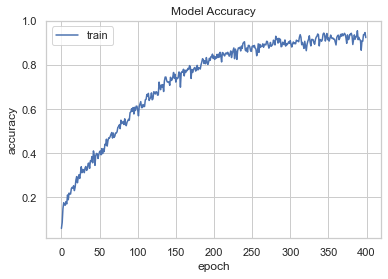

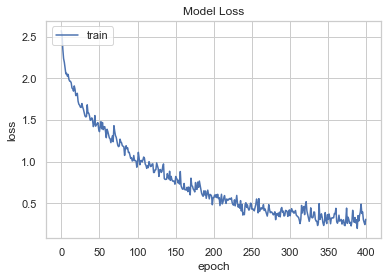

In [17]:
if TEST_MODEL is True:
    ##########################
    # # get model accuracy # #
    ##########################
    plt.plot(history.history['accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()

    ######################
    # # get model loss # #
    ######################
    plt.plot(history.history['loss'])
    plt.title('Model Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()

In [18]:
if TEST_MODEL is True:
    ##########################
    # # view model summary # #
    ##########################
    model.model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 1, 256)            488448    
                                                                 
 dense_25 (Dense)            (None, 1, 256)            65792     
                                                                 
 dropout_20 (Dropout)        (None, 1, 256)            0         
                                                                 
 batch_normalization_15 (Bat  (None, 1, 256)           1024      
 chNormalization)                                                
                                                                 
 lstm_21 (LSTM)              (None, 1, 128)            197120    
                                                                 
 dense_26 (Dense)            (None, 1, 128)            16512     
                                                      

#### MODEL TESTING
- Get Model Accuracy on the Test Dataset
- Generate Confusion Matrix
- Generate ROC Curves
- Save the Model if Appropriate

In [19]:
if TEST_MODEL is True:
    y_pred = model.predict_proba(X_test)

    # evaluate predictions
    acc = accuracy_score(lb.inverse_transform(y_test), lb.inverse_transform(y_pred))
    print("Testing accuracy: %.3f%%" % (acc*100))

Testing accuracy: 89.167%


##### Confusion Matrix

240 is the number of test value in kfold_val / train_test_split


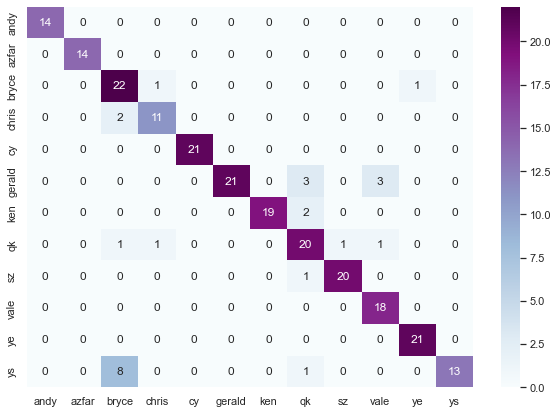

In [20]:
if TEST_MODEL is True and CON_MATRIX is True:
    # confusion matrix
    print(str(len(y_pred)) + " is the number of test value in kfold_val / train_test_split")
    cm = confusion_matrix(lb.inverse_transform(y_test), lb.inverse_transform(y_pred))
    df_cm = pd.DataFrame(cm, index = [i for i in np.unique(lb.inverse_transform(y_test))],
                         columns = [i for i in np.unique(lb.inverse_transform(y_test))])

    plt.figure(figsize = (10,7))
    sns.heatmap(df_cm, annot=True, cmap="BuPu")

##### ROC Curve (Individual)

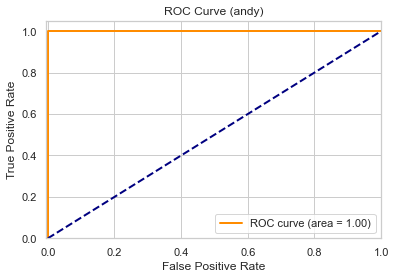

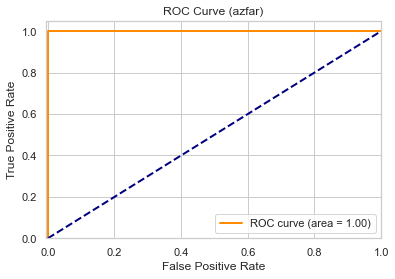

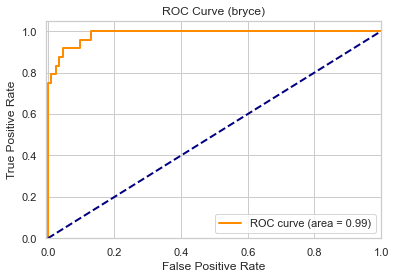

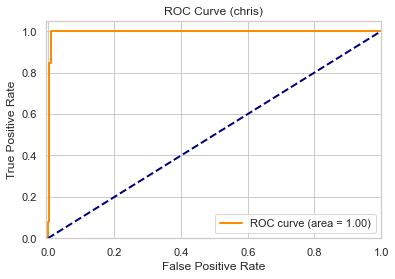

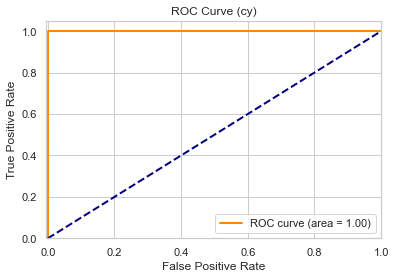

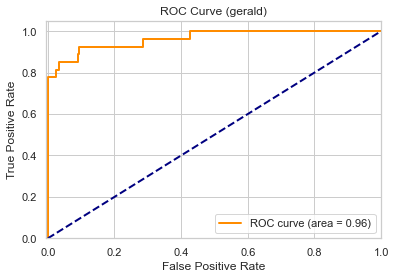

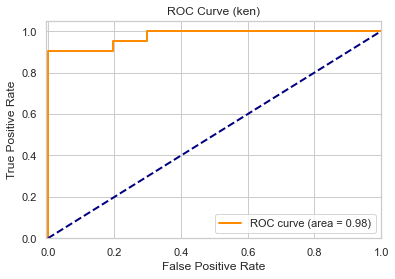

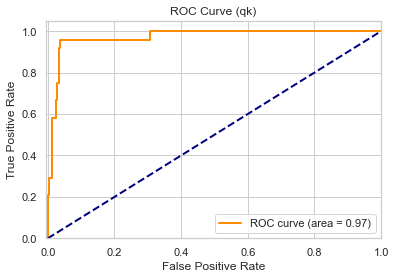

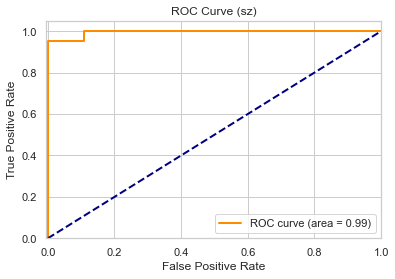

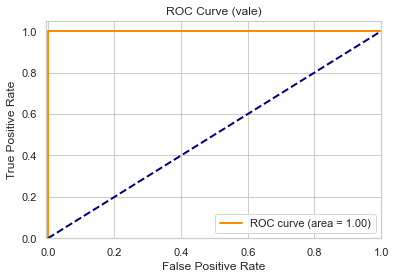

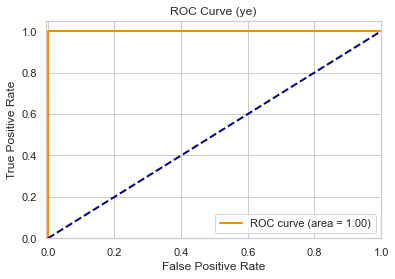

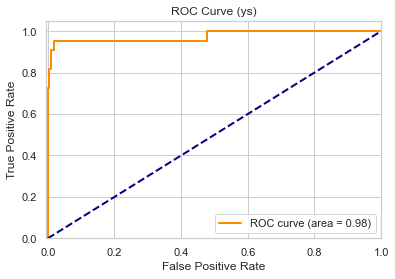

In [21]:
if TEST_MODEL is True and ROC_GRAPH is True: # compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    for i in range(n_classes):
        plt.figure()
        lw = 2
        plt.plot(
            fpr[i],
            tpr[i],
            color="darkorange",
            lw=lw,
            label="ROC curve (area = %0.2f)" % roc_auc[i],
        )
        plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
        plt.xlim([-0.005, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve (" + str(lb.classes_[i]) + ")")
        plt.legend(loc="lower right")
        plt.show()

##### ROC Curve (Multiclass)

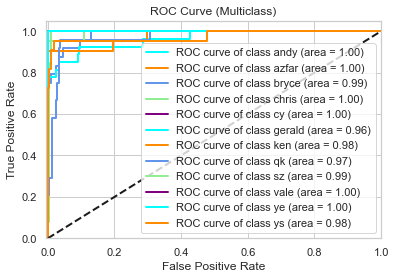

In [22]:
if TEST_MODEL is True and ROC_GRAPH is True:
    # compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], thresholds = roc_curve(y_test.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # first aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    # plt.figure()
    # plt.plot(
    #     fpr["micro"],
    #     tpr["micro"],
    #     label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    #     color="deeppink",
    #     linestyle=":",
    #     linewidth=4,
    # )

    # plt.plot(
    #     fpr["macro"],
    #     tpr["macro"],
    #     label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    #     color="navy",
    #     linestyle=":",
    #     linewidth=4,
    # )

    colors = cycle(["aqua", "darkorange", "cornflowerblue", "lightgreen", "purple"])
    for i, color in zip(range(n_classes), colors):
        plt.plot(
            fpr[i],
            tpr[i],
            color=color,
            lw=lw,
            label="ROC curve of class {0} (area = {1:0.2f})".format(lb.classes_[i], roc_auc[i]),
        )

    plt.plot([0, 1], [0, 1], "k--", lw=lw)
    plt.xlim([-0.005, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve (Multiclass)")
    plt.legend(loc="lower right")
    plt.show()

##### ROC Curve (Average)

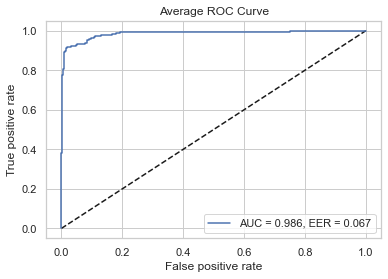

In [23]:
if TEST_MODEL is True and ROC_GRAPH is True:
    fpr, tpr, threshold = roc_curve(y_test.ravel(), y_pred.ravel())

    # calculate equal-error-rate
    eer = brentq(lambda x : 1. - x - interp1d(fpr, tpr)(x), 0., 1.)

    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label='AUC = {:.3f}, EER = {:.3f}'.format(auc(fpr, tpr), eer))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('Average ROC Curve')
    plt.legend(loc='best')
    plt.show()

#### FIT AND SAVE MODEL
- Fitting of model
- Get Accuracy and Loss of Mdoel
- Saving Model

In [ ]:
############################
# # reshaping of dataset # #
############################
# loading of dataset
df = pd.read_csv(SAMPLE_DATASET_PATH)

df.head()
dataset = df.values

# divide data into features X and target (classes) Y
# convert target Y to labelbinarizer Y for model
X, Y, lb, class_list = prepare_dataset(df)

# reshaping the dataset to include LSTM Timesteps
X = reshape_dataset(X, TIMESTEPS)
n_classes = Y.shape[1]

#####################
# # fit the model # #
#####################

model = create_model()
es = EarlyStopping(monitor='loss', mode='min', min_delta=0.001, patience=50,
                   verbose=0)
history = model.fit(X, Y, callbacks=es)

LabelBinarizer is able to decipher: 
['andy' 'azfar' 'bryce' 'chris' 'cy' 'gerald' 'ken' 'qk' 'sz' 'vale' 'ye'
 'ys']


X | Features | Dataset Shape: (1200, 220)
Y | Classes  | Dataset Shape: (1200, 12)
There are a total of 12 classes.
Epoch 1/400
120/120 [==============================] - 5s 11ms/step - loss: 2.6012 - accuracy: 0.0758
Epoch 2/400
120/120 [==============================] - 1s 10ms/step - loss: 2.4463 - accuracy: 0.1208
Epoch 3/400
120/120 [==============================] - 1s 10ms/step - loss: 2.2881 - accuracy: 0.1492
Epoch 4/400
120/120 [==============================] - 1s 10ms/step - loss: 2.1637 - accuracy: 0.1758
Epoch 5/400
120/120 [==============================] - 1s 9ms/step - loss: 2.0945 - accuracy: 0.1592
Epoch 6/400
120/120 [==============================] - 1s 10ms/step - loss: 2.0651 - accuracy: 0.1733
Epoch 7/400
120/120 [==============================] - 1s 9ms/step - loss: 2.0380 - accuracy: 0.1792
Epoch 8/400
120/120 [==============================]

Epoch 79/400
120/120 [==============================] - 1s 9ms/step - loss: 1.2716 - accuracy: 0.4792
Epoch 80/400
120/120 [==============================] - 1s 9ms/step - loss: 1.2533 - accuracy: 0.4750
Epoch 81/400
120/120 [==============================] - 1s 9ms/step - loss: 1.2520 - accuracy: 0.5017
Epoch 82/400
120/120 [==============================] - 1s 9ms/step - loss: 1.1956 - accuracy: 0.5400
Epoch 83/400
120/120 [==============================] - 1s 9ms/step - loss: 1.2129 - accuracy: 0.5108
Epoch 84/400
120/120 [==============================] - 1s 9ms/step - loss: 1.2350 - accuracy: 0.5217
Epoch 85/400
120/120 [==============================] - 1s 9ms/step - loss: 1.1728 - accuracy: 0.5258
Epoch 86/400
120/120 [==============================] - 1s 9ms/step - loss: 1.2580 - accuracy: 0.5025
Epoch 87/400
120/120 [==============================] - 1s 9ms/step - loss: 1.3814 - accuracy: 0.4908
Epoch 88/400
120/120 [==============================] - 1s 9ms/step - loss: 1.2087

120/120 [==============================] - 1s 9ms/step - loss: 0.6729 - accuracy: 0.7842
Epoch 159/400
120/120 [==============================] - 1s 9ms/step - loss: 0.6682 - accuracy: 0.7833
Epoch 160/400
120/120 [==============================] - 1s 9ms/step - loss: 0.6793 - accuracy: 0.7850
Epoch 161/400
120/120 [==============================] - 1s 9ms/step - loss: 0.7139 - accuracy: 0.7658
Epoch 162/400
120/120 [==============================] - 1s 10ms/step - loss: 0.7191 - accuracy: 0.7700
Epoch 163/400
120/120 [==============================] - 1s 10ms/step - loss: 0.7018 - accuracy: 0.7725
Epoch 164/400
120/120 [==============================] - 1s 9ms/step - loss: 0.6476 - accuracy: 0.7900
Epoch 165/400
120/120 [==============================] - 1s 9ms/step - loss: 0.6518 - accuracy: 0.7783
Epoch 166/400
120/120 [==============================] - 1s 9ms/step - loss: 0.7032 - accuracy: 0.7825
Epoch 167/400
120/120 [==============================] - 1s 9ms/step - loss: 0.7001 -

In [ ]:
##########################
# # get model accuracy # #
##########################
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

######################
# # get model loss # #
######################
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

#### SAVE MODEL

In [ ]:
##################
# # save model # #
##################
model.model.save(MODEL_PATH)

# LIVE TESTING
> Live test with new dataset to check if model function as it should

#### LOAD MODEL

In [ ]:
##################
# # load model # #
##################

# model = create_model()
model = load_model(MODEL_PATH)

#### LOAD DATA
- Import new dataset to verify the model is able to predict accurately

In [ ]:
# import unseen data
pred_df = pd.read_csv(ACTUAL_DATASET_PATH)
pred_df.head()

In [ ]:
################################
# # check for class validity # #
################################
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="Subject", data=pred_df).set_title("Class Validity")

# remove missing values if available
pred_df = pred_df.dropna()

In [ ]:
pred_dataset = pred_df.values
actual_np = pred_dataset[:,CLASSES_COL_NUM]

# # divide data into features X
# pred_row = pred_dataset[:,3:].astype(float)

########################
# # predict all rows # #
########################
pred_row=pred_df.iloc[:,FEATURES_COL_NUM:]

#################################
# # predict more than one row # #
#################################

# pred_row=pred_df.iloc[46:54,FEATURES_COL_NUM:]
# print(pred_row)

############################
# # predict a single row # #
############################

# pred_row=pred_df.iloc[11:12,FEATURES_COL_NUM:]

##################
# # shape data # #
##################
pred_row = pred_row.values.tolist()
pred_arr = np.asarray(pred_row, dtype=np.float32)
pred_arr = np.reshape(pred_arr, (pred_arr.shape[0], TIMESTEPS, pred_arr.shape[1]))

print(class_list)
Y = np.asarray(class_list)
Y = Y.reshape(-1, 1)
lb = LabelBinarizer().fit(Y)
Y = lb.transform(Y)

In [ ]:
####################################
# # get prediction and its label # #
####################################

pred_proba = model.predict(pred_arr)

# pred_proba = np.sum(pred_proba, axis=0)
# pred_proba = np.reshape(pred_proba, (1, 9))

pred = lb.inverse_transform(pred_proba)
acc = np.max(pred_proba, axis=1)

match_list = []

for _ in range(actual_np.size):
    if pred[_] == actual_np[_]:
        match_list.append("match")
    else:
        match_list.append("nope")

match_count = match_list.count("match")
total_count = len(match_list)

match_header = str(match_count) + "/" + str(total_count) + " (" + str(match_count/total_count*100)+ "%)"
match_np = np.array(match_list)

exported_output = np.column_stack((actual_np, pred))
exported_output = np.column_stack((exported_output, acc))
exported_output = np.column_stack((exported_output, match_np))

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

df = pd.DataFrame(data=exported_output, index=None, columns=['Actual', 'Prediction', 'Accuracy', match_header])
# print(df)
df.to_csv(RESULT_PATH)

print("Accuracy of the Model is: " + str(match_header))

In [ ]:
# print elapsed time
elapsed_time = time.time() - start_time
print('Execution time:', time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))